In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM,Dense,GRU,Dropout

import matplotlib.pyplot as plt
%matplotlib inline  

from copy import deepcopy

from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
original_data = pd.read_csv("data.csv", parse_dates = ['Date'])

df = deepcopy(original_data)

df = df[df["Region"] != "global"]

In [3]:
# From https://www.kaggle.com/connerbrown/visualization-and-exploration
# Remove all NaN
df_nans = df.isnull()

track_name_nans = df_nans['Track Name'][df_nans['Track Name'] == True].index
artist_nans = df_nans['Artist'][df_nans['Artist'] == True].index
nans_overlap = (track_name_nans == artist_nans).sum() / df_nans['Track Name'].sum() * 100.0

df = df.drop(track_name_nans)

In [4]:
songs = ["Eraser", "Castle on the Hill", "Dive", "Shape of You", "Perfect", "Galway Girl", "Happier", "New Man", "Hearts Don't Break Around Here", "Supermarket Flowers"]

song = ["Shape of You"]
df_train = df[df.isin({"Track Name": song})['Track Name']]


In [5]:
# Use data later than March 3rd and earlier than December 1st to improve accuracy
df_train_cut = df_train[df_train['Date'] >= datetime(2017, 3, 3)][df_train['Date'] < datetime(2017, 12, 1)]
df_train_reshape = df_train_cut.pivot_table(index = 'Date',columns = ['Track Name', 'Region'],values = 'Streams')\
                    .dropna(axis = 'columns')

# Reshape to build feature
df_train_reshape.columns = ["_".join(x) for x in df_train_reshape.columns.ravel()]

# Set first column to be label
label_index = np.argwhere(np.array(df_train_reshape.columns) == "Shape of You_us")[0][0]

cols = df_train_reshape.columns.tolist()

cols = [cols[label_index]] + cols[:label_index] + cols[label_index + 1:]

df_train_reshape = df_train_reshape[cols]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [6]:
df_train_reshape.head(10)

,Shape of You_us,Shape of You_ar,Shape of You_at,Shape of You_au,Shape of You_be,Shape of You_bo,Shape of You_br,Shape of You_ca,Shape of You_ch,Shape of You_cl,...,Shape of You_ph,Shape of You_pl,Shape of You_pt,Shape of You_py,Shape of You_se,Shape of You_sg,Shape of You_sv,Shape of You_tr,Shape of You_tw,Shape of You_uy
Date,,,,,,,,,,,,,,,,,,,,,
2017-03-03,2160086.0,202857.0,39655.0,327711.0,67779.0,7739.0,472393.0,330241.0,66237.0,124430.0,...,356931.0,114206.0,55992.0,11532.0,434313.0,91196.0,7772.0,92352.0,36862.0,15129.0
2017-03-04,2089935.0,193463.0,39561.0,311933.0,66950.0,7522.0,431590.0,329328.0,62291.0,116720.0,...,363832.0,113369.0,55905.0,10738.0,385646.0,88528.0,8373.0,87233.0,34535.0,12909.0
2017-03-05,1854260.0,176277.0,34746.0,311668.0,63547.0,6864.0,360825.0,302368.0,54876.0,108277.0,...,366702.0,103094.0,48204.0,10396.0,309256.0,90434.0,7402.0,86897.0,33856.0,12383.0
2017-03-06,2069243.0,184620.0,33632.0,310771.0,55626.0,7857.0,428598.0,321836.0,57360.0,119525.0,...,361321.0,101081.0,53385.0,11200.0,338734.0,93212.0,7343.0,88530.0,37433.0,13896.0
2017-03-07,2060254.0,184778.0,33587.0,302044.0,55930.0,8039.0,438241.0,310694.0,55009.0,119828.0,...,363367.0,94890.0,54658.0,11887.0,336700.0,92116.0,7705.0,89742.0,34109.0,13689.0
2017-03-08,2042042.0,185182.0,32185.0,300861.0,61895.0,8149.0,415145.0,311758.0,56264.0,119747.0,...,349893.0,94041.0,55132.0,11432.0,327348.0,89346.0,7682.0,87211.0,38305.0,13409.0
2017-03-09,1990545.0,179599.0,31917.0,302627.0,57635.0,8328.0,423503.0,305764.0,55354.0,120478.0,...,367367.0,96597.0,52855.0,11465.0,336546.0,92054.0,7524.0,86128.0,34720.0,12695.0
2017-03-10,1957676.0,185765.0,34840.0,290630.0,57992.0,7985.0,438461.0,303575.0,58184.0,128234.0,...,352832.0,94121.0,54227.0,11477.0,376328.0,87401.0,7424.0,84438.0,34805.0,13417.0
2017-03-11,1813540.0,185677.0,34749.0,287189.0,68655.0,7948.0,416651.0,286104.0,59772.0,126615.0,...,357433.0,99431.0,53476.0,11857.0,355436.0,83778.0,7694.0,82797.0,34030.0,12633.0


In [7]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(np.array(df_train_reshape))
print(dataset.shape)

(270, 47)


In [8]:
# Build train, valid, test set
def processData(data, window):
    X,Y = [],[]
    for i in range(len(data) - window):
        X.append(data[i:(i + window), :data.shape[1]])
        Y.append(data[(i + window), 0])
    return np.array(X),np.array(Y)

window_size = 7
train_size = 0.7
valid_size = 0.15

X,y = processData(dataset, window_size)
print(X.shape)
X_train,X_valid,X_test = X[:int(X.shape[0] * train_size)],\
                        X[int(X.shape[0] * train_size):int(X.shape[0] * (train_size + valid_size))],\
                        X[int(X.shape[0] * (train_size + valid_size)):]

y_train,y_valid,y_test = y[:int(y.shape[0] * train_size)],\
                        y[int(y.shape[0] * train_size):int(y.shape[0] * (train_size + valid_size))],\
                        y[int(y.shape[0] * (train_size + valid_size)):]
print(y_train.shape)

(263, 7, 47)
(184,)


In [13]:
# Build LSTM model
model = Sequential()
model.add(LSTM(512,input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences = True))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(LSTM(512))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_train.shape[2]))
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], X_train.shape[2]))

#Fit model
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid,y_valid), shuffle=False)

Train on 184 samples, validate on 39 samples
Epoch 1/50
184/184 [==============================] - 5s 29ms/step - loss: 0.4092 - val_loss: 0.0090
Epoch 2/50
184/184 [==============================] - 1s 7ms/step - loss: 0.1911 - val_loss: 0.0073
Epoch 3/50
184/184 [==============================] - 1s 7ms/step - loss: 0.0270 - val_loss: 0.0147
Epoch 4/50
184/184 [==============================] - 1s 7ms/step - loss: 0.1318 - val_loss: 0.0068
Epoch 5/50
184/184 [==============================] - 1s 7ms/step - loss: 0.0327 - val_loss: 1.3374e-04
Epoch 6/50
184/184 [==============================] - 1s 7ms/step - loss: 0.0136 - val_loss: 9.0115e-04
Epoch 7/50
184/184 [==============================] - 1s 7ms/step - loss: 0.0189 - val_loss: 1.4500e-04
Epoch 8/50
184/184 [==============================] - 1s 8ms/step - loss: 0.0068 - val_loss: 1.7047e-04
Epoch 9/50
184/184 [==============================] - 2s 9ms/step - loss: 0.0035 - val_loss: 0.0017
Epoch 10/50
184/184 [=================

0.0002033467231456661

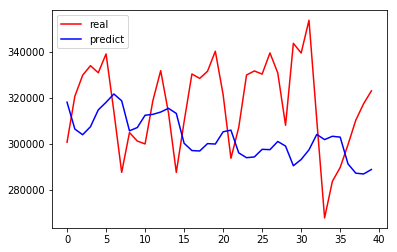

In [14]:
# Get original data
y_test = y_test.reshape(-1, 1)
y_inverse = np.concatenate((y_test, X_test[:,0, 1:]), axis=1)
y_inverse = scaler.inverse_transform(y_inverse)
y_inverse = y_inverse[:,0]

X_pred = model.predict(X_test)
X_pred = X_pred.reshape(-1, 1)
X_pred_inverse = np.concatenate((X_pred, X_test[:,0, 1:]), axis=1)
X_pred_inverse = scaler.inverse_transform(X_pred_inverse)
X_pred_inverse = X_pred_inverse[:,0]

real, = plt.plot(y_inverse, color = 'red')
predict, = plt.plot(X_pred_inverse, color = 'blue')
plt.legend(handles = [real, predict,], labels = ['real', 'predict'], loc = 'best')

mean_squared_error(y_test, X_pred)